In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import plotly.express as px
import plotly.graph_objects as go

In [2]:
plt.style.use("ggplot")

In [3]:
path_dir = "./csv/"
stock_column = ["STK_CD", "STK_NM", "EX_CD", "NAT_CD", "SEC_NM", "STK_TP_NM"]
history_column = ["STK_CD", "DT", "O_PRC", "H_PRC", "L_PRC", "C_PRC", "VOL", "CHG_RT", "M3_PRC", "M5_PRC", "M10_PRC", "M20_PRC", "M60_PRC", "M3_VOL", "M5_VOL", "M10_VOL", "M20_VOL", "M60_VOL", "STK_DT_NO"]
finance_column = ["YY", "STK_CD", "FIN_ITM_NM", "FIN_ITM_VAL", "DAT_SOU"]
history = pd.read_csv(path_dir + "history_dt.csv", names=history_column, encoding="cp949", low_memory=False)
finance = pd.read_csv(path_dir + "finance_y.csv", names=finance_column, encoding="utf-8-sig")
stock   = pd.read_csv(path_dir + "stock.csv", names=stock_column, encoding="utf-8-sig")

In [4]:
# csv 필터 및 데이터 타입변경 함수 모음

def history_filter_csv(csv, stk_code, start_day, end_day, filter_column=None):
    filter = csv.copy();
    filter = filter[filter["STK_CD"] == stk_code]
    filter = filter[(filter["DT"] >= start_day) & (filter["DT"] <= end_day)]
    if filter_column is not None:
        filter = filter[filter_column]
    return filter

def history_init_csv(csv):
    csv["DT"] = pd.to_datetime(csv["DT"])
    csv["C_PRC"] = csv["C_PRC"].astype("int64") 
    return csv

In [5]:
# 볼랜저밴드 구하는 함수 모음

def Moving_average(csv, Days):
    # 라벨 명칭
    MA_csv = csv.copy()
    MA_label = f"MA{Days}"
    STD_label = f"STDDEV{Days}"
    UP_label = f"Upper{Days}B"
    LOW_label = f"Lower{Days}B"
    label_name_list = [MA_label, STD_label, UP_label, LOW_label]

    # N일간 종가의 이동평균
    MA_csv[MA_label] = MA_csv["C_PRC"].rolling(Days).mean()
    
    # N일간 주가의 표준편차
    MA_csv[STD_label] = MA_csv["C_PRC"].rolling(Days).std()
    
    # 상위 밴드
    # UpperB = 종가의 이동평균 + (표준편차 * 2)
    MA_csv[UP_label] = MA_csv[MA_label] + (MA_csv[STD_label] * 2)

    # 하위밴드
    # LowerB = 종가의 이동평균 - (표준편차 * 2)
    MA_csv[LOW_label] = MA_csv[MA_label] - (MA_csv[STD_label] * 2)

    return MA_csv, label_name_list

def Bollinger_Bands(csv, label_list, title="None"):
    MA_label, STD_label, UP_label, LOW_label = tuple([label for label in label_list])
    
    # 그래프의 크기 가로 30 세로 10
    plt.figure(figsize=(15, 5))
    
    # 상위 밴드 : 주식의 가격이 움직이는 밴드의 상위값 (빨강색으로 표시)
    plt.plot(csv["DT"], csv[UP_label], "r--")
    # 실제 주식의 가격 (종가) : 검정색
    plt.plot(csv["DT"], csv["C_PRC"], "k")
    # 하위밴드 : 주식이 움직이는 가격이 움직이는 밴드의 하위값 (하위값)
    plt.plot(csv["DT"], csv[LOW_label], "b--")

    # 각 날짜의 df.LowerB(하위밴드) ~ df.UpperB (상위밴드) 사이를 색을 칠함
    plt.fill_between(csv["DT"], csv[LOW_label], csv[UP_label], alpha=0.2)

    plt.title(title, fontsize=25) # 제목

    return plt;

def Percent_Bands(csv, label_list, Days, title = None):
    np.set_printoptions(suppress=True, precision=4)
    bands_csv = csv.copy()
    MA_label, STD_label, UP_label, LOW_label = tuple([label for label in label_list])

    # PercentB = (종가 - 하위밴드) / (상위밴드 - 하위밴드)
    percent_label = f"Percent{Days}B"
    bands_csv[percent_label] = (bands_csv["C_PRC"] - bands_csv[LOW_label]) / (bands_csv[UP_label] - bands_csv[LOW_label])
    # 밴드 내에서 주가의 상대적인 위치를 시각화 합니다.
    # 1보다 크면 밴드폭 상단을 돌파한 것이고
    # 0보다 작으면 밴드폭 하단을 뚫고 내려간 것입니다.

    # 그래프의 크기 가로 15 세로 5
    plt.figure(figsize=(15, 5))
    # 밴드내에서 주가의 상대 위치를 막대 그래프로 출력
    plt.bar(bands_csv["DT"], bands_csv[percent_label])

    # 1 지점에 선그림 (빨강색) -> 1보다 크면 밴드폭 상단을 돌파한 것이고
    plt.axhline(1, c="r", lw=1)
    # 0.5 지점에 선그림 (파랑색)
    plt.axhline(0.5, c="b", lw=1)
    # 0 지점에 선그림 (검정색) -> 0보다 작으면 밴드폭 하단을 뚫고 내려간 것입니다.
    plt.axhline(0, c="k", lw=1)

    plt.title(title, fontsize=25) # 제목

    return bands_csv, plt

In [6]:
# 모뎀텀 지표 구하는 함수 모음

def RSI_UD(diff):
    """
    diff 값을 입력받아 0이면 ups, downs을 0으로 
    0보다 크면 ups 에 diff값을 작으면 downs 에 abs(diff) 값을 반환합니다.
    ups = 전날 주가보다 오늘 주가가 상승할 때의 주가 상승폭(up)
    downs = 전날 주가보다 오늘 주가가 하락할 때의 주가 하락폭(down)
    """
    ups = 0
    downs = 0
    # 전날주가 - 오늘주가가 0 초과
    if diff > 0:
        # 상승치를 ups에 대입
        ups = diff
    elif diff < 0: # 전날주가 - 오늘주가가 0 미만
        # 하락치의 절대값 (abs)를 downs 에 대입
        downs = abs(diff)
    # ups와 downs 를 Series(DataFrame 칸) 으로 만들어서 리턴    
    return pd.Series([ups, downs])

def RSI_Data_csv(csv, Days, RSIDays):
    rsi_csv = csv.copy()
    # diff() : 함수는 윗줄 (하루전) 데이터와 아래줄 데이터(현재)의 차를 계산
    rsi_csv["diff"] = rsi_csv["C_PRC"].diff()

    # df["diff"] 컬럼 데이터에 UD 함수를 실행해서 상승분과 하락분을 계산하고
    # 상승분은 U, 하락분은 D 컬럼에 저장
    rsi_csv[["U", "D"]] = rsi_csv["diff"].apply(RSI_UD)

    # AU = 일정기간(N일,보통14일) 동안의 U의 평균값(average ups)
    rsi_csv["AU"] = rsi_csv["U"].rolling(Days).mean()

    # AD = 일정기간(N일,보통14일) 동안의 D의 평균값(average downs)
    rsi_csv["AD"] = rsi_csv["D"].rolling(Days).mean()

    # RS = AU(일정기간(N일,보통14일) 동안의 U의 평균값(average ups) ) / AD (일정기간(N일,보통14일) 동안의 D의 평균값(average downs))
    rsi_csv["RS"] = rsi_csv["AU"] / rsi_csv["AD"]

    #AU / (AU+AD) = RS / (1+RS)
    rsi_csv["RSI"] = rsi_csv["RS"] / (1 + rsi_csv["RS"])

    # DT 컬럼 (날짜) 를 인덱스로 설정
    rsi_csv = rsi_csv.set_index("DT")

    # RSI_signal 변수를 생성합니다.
    rsi_csv['RSI_signal'] = rsi_csv["RSI"].rolling(RSIDays).mean()

    return rsi_csv

def RSI_Graph(csv, code):
    # 종가를 시각화 합니다.
    c_prc_plt = csv["C_PRC"].plot(figsize=(15, 5), title=f"C_PRC_PLT_{code}")

    # 'RSI','RSI_signal' 을 시각화 합니다.
    rsi_plt = csv[["RSI", "RSI_signal"]].plot(figsize=(15, 5), title=f"RSI_{code}")
    # RSI 가 70퍼센트 지점에 빨강색 선 ->  RSI가 70% 이상이면 매수세가 상당히 커서 초과매수 국면에 돌입했다고 판단합니다.
    rsi_plt.axhline(0.7, c="r", ls="--")
    # RSI 가 50 퍼센트 지점에 검정색 선 -> RSI는 50%를 기준으로, 50% 이상은 매수세 우세, 50% 이하는 매도세 우세를 나타냅니다.
    rsi_plt.axhline(0.5, c="k", ls="--")
    # RSI 가 30 퍼센트 지점에 파랑색 선 ->  RSI가 30% 이하이면 매도세가 상당히 커서 초과매도 국면에 돌입했다고 판단합니다.
    rsi_plt.axhline(0.3, c="b", ls="--")

    return c_prc_plt, rsi_plt

In [7]:
# MACD 파일

def MACD_Graph(csv, columns, MACD_Bool, code):
    if MACD_Bool:
        macd_plt = px.line(csv[columns], title=f"MACD_{code}", height=500)
        macd_plt.add_hline(0)
    else:
        macd_plt = px.line(csv[columns], title=f"EMA_{code}", height=500)
    return macd_plt;

def MACD_oscillator_Graph(csv, code):
    macd_osc_plt = px.bar(csv["macdhist"], title=f"MACD_oscillator_{code}", height=300)
    return macd_osc_plt

def MACD_DATA_CSV(csv, shortDay = 12, longDay = 26, MoveDay = 9):
    macd_csv = csv.copy()
    # 12일 지수이동평균을 구합니다.
    macd_csv["ema_short"] = macd_csv["C_PRC"].ewm(shortDay).mean()

    # 26일 지수이동평균을 구합니다.
    macd_csv["ema_long"] = macd_csv["C_PRC"].ewm(longDay).mean()

    # 거래일 DT를 인덱스로 설정 합니다
    macd_csv = macd_csv.set_index("DT")

    # MACD = 단기 지수이동평균(12일 지수 이동 평균) - 장기 지수이동평균 (26일 지수 이동 평균)
    macd_csv["MACD"] = macd_csv["ema_short"] - macd_csv["ema_long"]

    # MACD의 9일 이동평균값을 구합니다.
    macd_csv["signal"] = macd_csv["MACD"].ewm(MoveDay).mean()

    # MACD oscillator 계산
    macd_csv["macdhist"] = macd_csv["MACD"] - macd_csv["signal"]

    return macd_csv

In [8]:
def Bollinger_Bands_Main(csv, stk_code, start_day, end_day, Days):
    column = ['STK_CD', 'DT', 'C_PRC']
    history_csv = history_filter_csv(csv, stk_code, start_day, end_day, column)
    history_csv = history_init_csv(history_csv)
    MA_Days, MA_Labels = Moving_average(history_csv, Days)
    title = f"Bollinger_Bands_{stk_code}_By_{Days}"
    MA_plt = Bollinger_Bands(MA_Days, MA_Labels, title)
    title = f"Percent_Bands_{stk_code}_By_{Days}"
    Per_csv, Per_plt = Percent_Bands(MA_Days, MA_Labels, Days, title)

    return MA_Days, MA_plt, Per_csv, Per_plt;

In [9]:
def RSI_Main(csv, stk_code, start_day, end_day, Days):
    column = ['STK_CD', 'DT', 'C_PRC', 'O_PRC', 'H_PRC', 'L_PRC', 'VOL']

    history_csv = history_filter_csv(csv, stk_code, start_day, end_day, column)
    history_csv = history_init_csv(history_csv)
    
    RSIDays = 14
    rsi_csv = RSI_Data_csv(history_csv, Days, RSIDays)

    c_prc_plt, rsi_plt = RSI_Graph(rsi_csv, stk_code)

    return rsi_csv, c_prc_plt, rsi_plt

In [10]:
def MACD_MAIN(csv, stk_code, start_day, end_day, shortDay, longDay, MoveDay):
    column = ['STK_CD', 'DT', 'C_PRC', 'O_PRC', 'H_PRC', 'L_PRC', 'VOL']

    history_csv = history_filter_csv(csv, stk_code, start_day, end_day, column)
    history_csv = history_init_csv(history_csv)

    ema_columns = ["C_PRC", "ema_short", "ema_long"]
    macd_columns = ["MACD", "signal"]

    macd_csv = MACD_DATA_CSV(history_csv, shortDay, longDay, MoveDay)

    ema_plt = MACD_Graph(macd_csv, ema_columns, False, stk_code)
    macd_plt = MACD_Graph(macd_csv, macd_columns, True, stk_code)
    MACD_oscillator_plt = MACD_oscillator_Graph(macd_csv, stk_code)

    return macd_csv, ema_plt, macd_plt, MACD_oscillator_plt

In [20]:
stk_code = '247540'
start_day = '2019-01-02'
end_day = '2020-03-19'

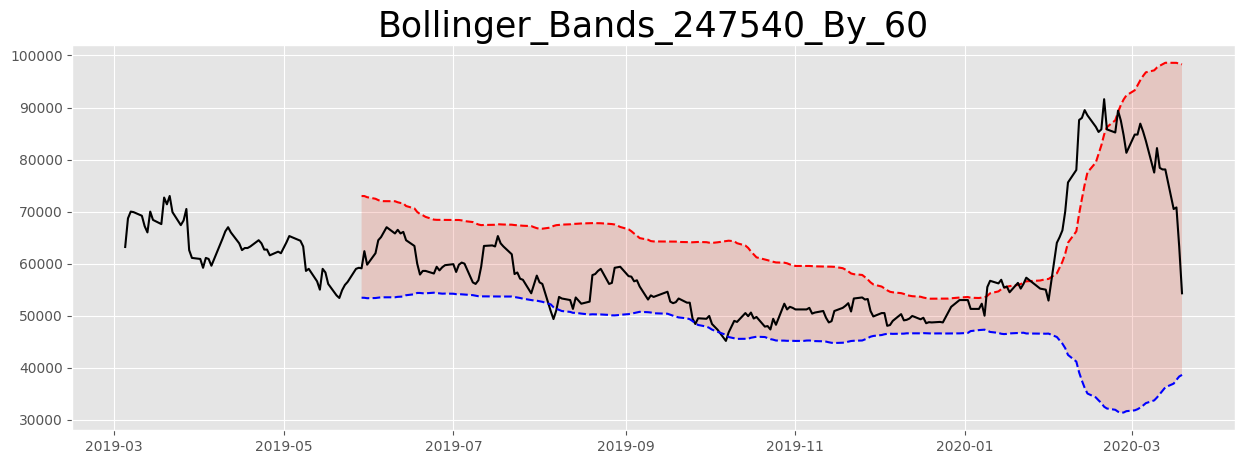

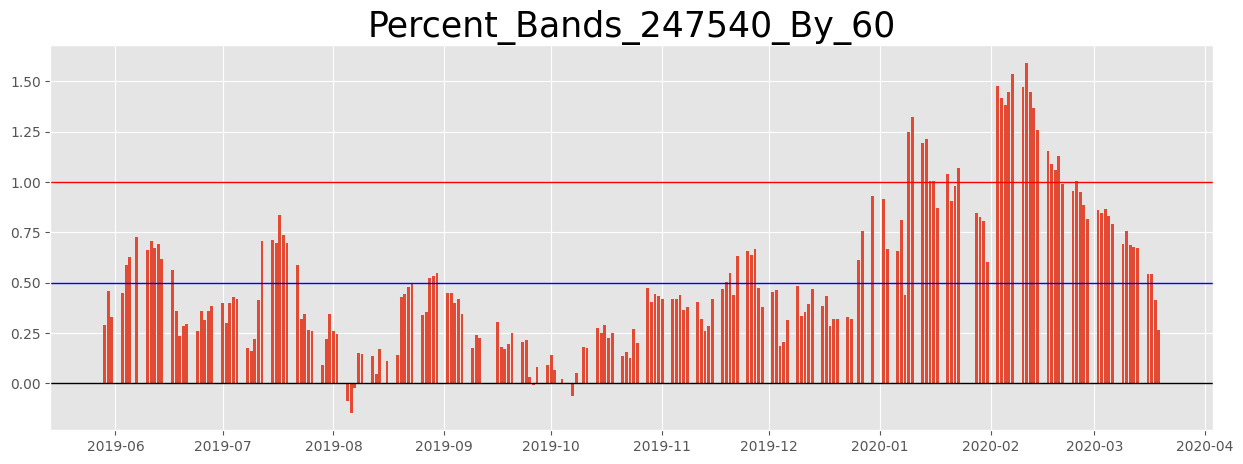

In [21]:
MA60_csv, MA60_plt, Per60_csv, Per60_plt = Bollinger_Bands_Main(history, stk_code, start_day, end_day, Days = 60)

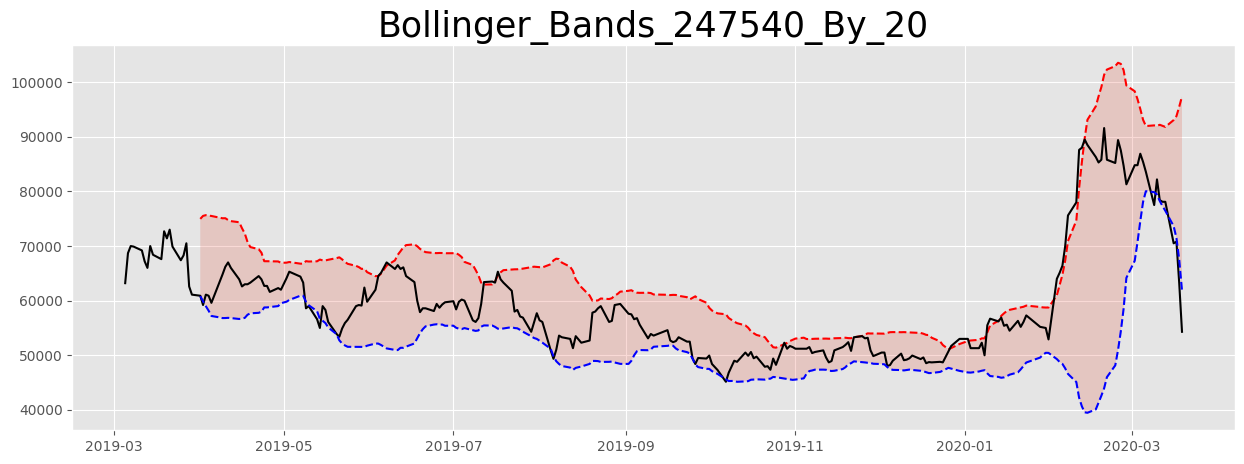

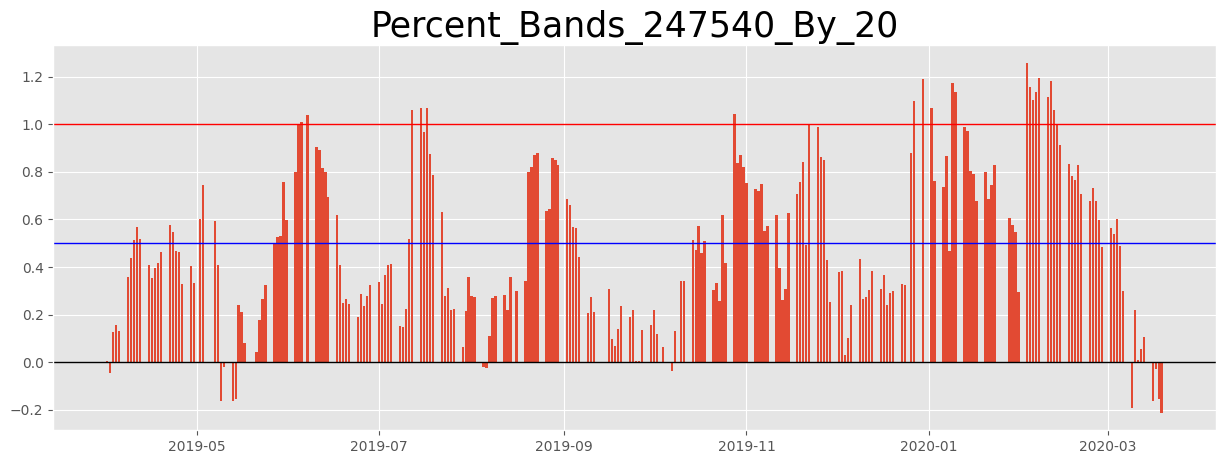

In [22]:
MA20_csv, MA20_plt, Per20_csv, Per20_plt = Bollinger_Bands_Main(history, stk_code, start_day, end_day, Days = 20)

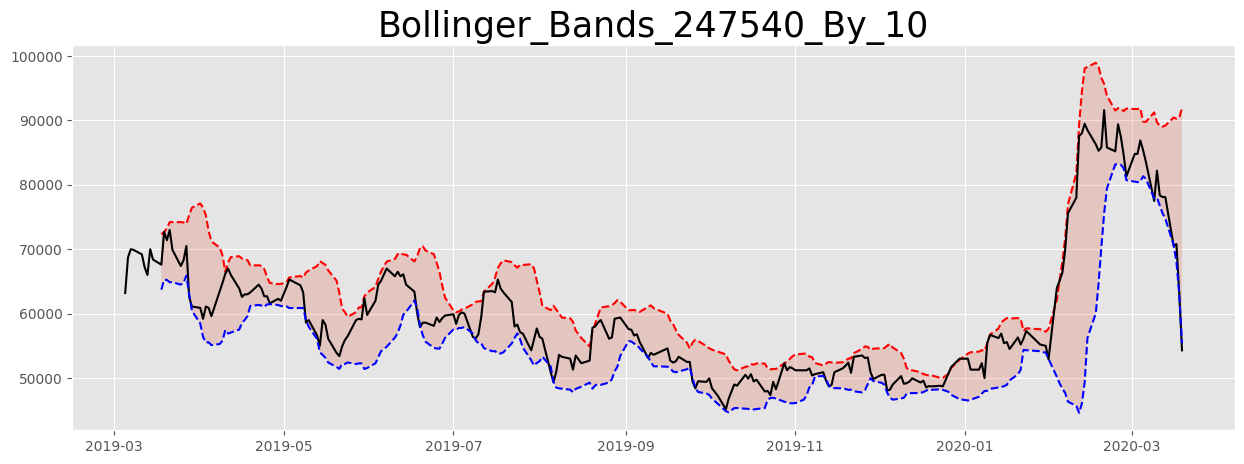

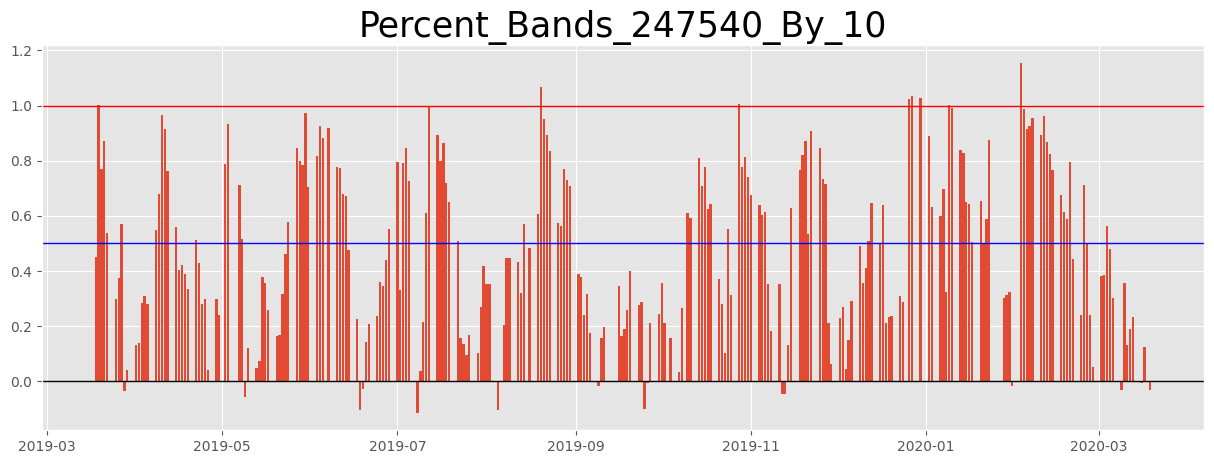

In [23]:
MA10_csv, MA10_plt, Per10_csv, Per10_plt = Bollinger_Bands_Main(history, stk_code, start_day, end_day, Days = 10)

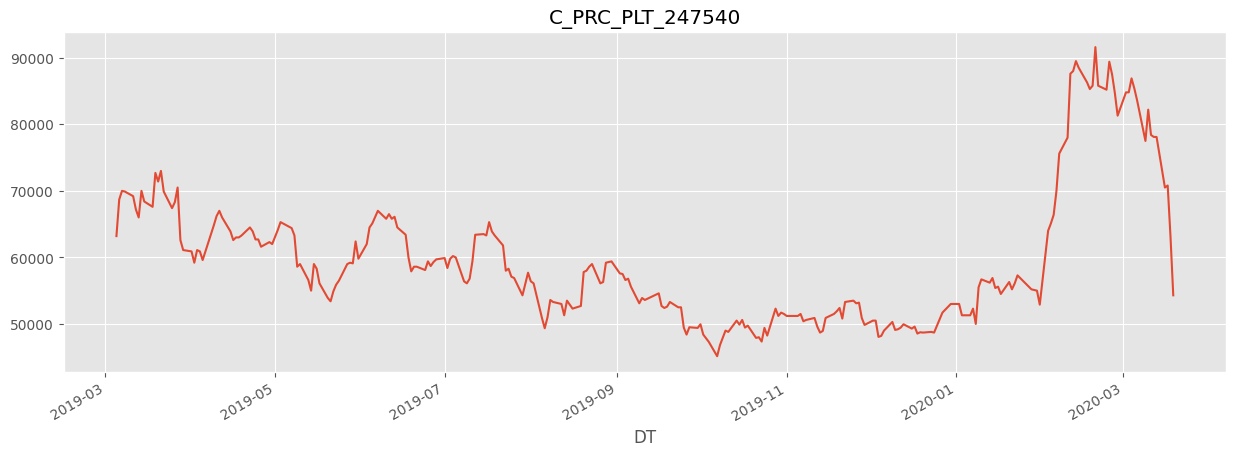

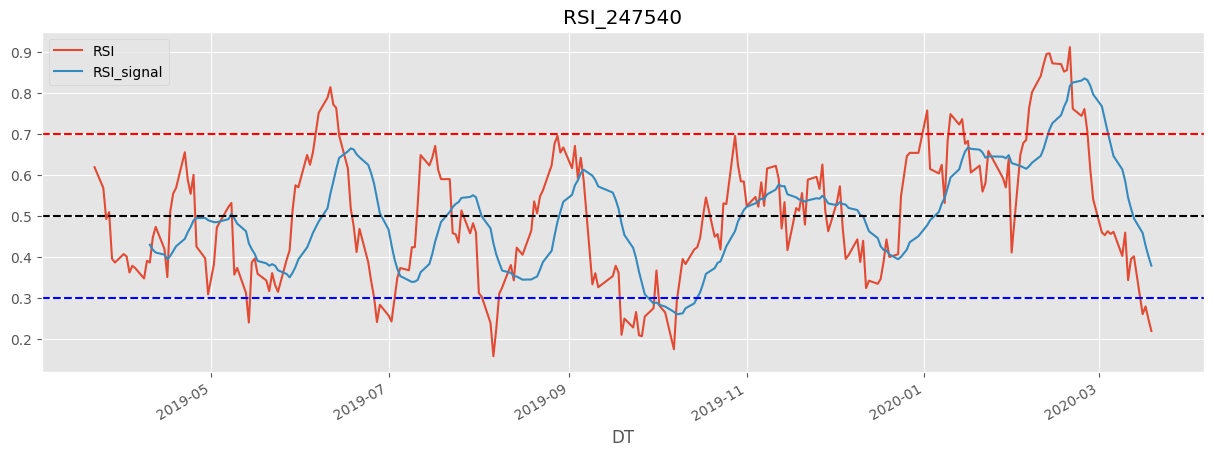

In [24]:
rsi_csv, c_prc_plt, rsi_plt = RSI_Main(history, stk_code, start_day, end_day, Days=14)

In [25]:
macd_csv, ema_plt, macd_plt, MACD_oscillator_plt = MACD_MAIN(history, stk_code, start_day, end_day, shortDay = 12, longDay = 26, MoveDay = 9)

In [26]:
ema_plt

In [27]:
macd_plt

In [28]:
MACD_oscillator_plt